<a href="https://colab.research.google.com/github/SPS-L/pyeplan/blob/master/examples/Watoto_Village_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Watoto Village Case study using PyEPLAN

This is an example of using PyEPLAN to design a Microgrid on Watoto Village in Uganda.

It is designed to be ran on Google Colab.

 **Importing data files**

In [45]:
!rm -r sample_data
!rm -r wat_inv

rm: cannot remove 'sample_data': No such file or directory


In [46]:
!apt-get install -qq subversion
!svn export https://github.com/SPS-L/pyeplan/trunk/examples/wat_inv

A    wat_inv
A    wat_inv/.gitignore
A    wat_inv/cbat_dist.csv
A    wat_inv/cblt_dist.csv
A    wat_inv/cgen_dist.csv
A    wat_inv/clin_dist.csv
A    wat_inv/csol_dist.csv
A    wat_inv/cwin_dist.csv
A    wat_inv/dtim_dist.csv
A    wat_inv/egen_dist.csv
A    wat_inv/elin_dist.csv
A    wat_inv/esol_dist.csv
A    wat_inv/ewin_dist.csv
A    wat_inv/geol_dist.csv
A    wat_inv/mgpc_dist.xlsx
A    wat_inv/pdem_dist.csv
A    wat_inv/power_chrono.csv
A    wat_inv/prep_dist.csv
A    wat_inv/psol_dist.csv
A    wat_inv/pwin_dist.csv
A    wat_inv/qdem_dist.csv
A    wat_inv/qrep_dist.csv
A    wat_inv/qsol_dist.csv
A    wat_inv/qwin_dist.csv
A    wat_inv/rou_dist.csv
Exported revision 132.


**Installing required packages**

In [47]:
!apt-get install -y -qq glpk-utils

In [48]:
!apt-get install -y -qq coinor-cbc

In [49]:
!pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Installing PYEPLAN**

In [50]:
!pip install -q pyeplan

In [51]:
!pip install git+git://github.com/SPS-L/pyeplan@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning git://github.com/SPS-L/pyeplan (to revision master) to /tmp/pip-req-build-6u3cvlts
  Running command git clone -q git://github.com/SPS-L/pyeplan /tmp/pip-req-build-6u3cvlts
  fatal: unable to connect to github.com:
  github.com[0: 192.30.255.113]: errno=Connection timed out

ERROR: Command errored out with exit status 128: git clone -q git://github.com/SPS-L/pyeplan /tmp/pip-req-build-6u3cvlts Check the logs for full command output.


In [52]:
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Importing all modules in PYEPLAN**



In [53]:
import pyeplan as pe

## Obtaining the PV generation profiles

In [54]:
datsys = pe.datsys('wat_inv', lat=0.251148605450955, lon=32.404833929733, year=2016)

In [55]:
datsys.data_extract()

In [56]:
datsys.kmeans_clust()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['time']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['time']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['time']. An error will be raised in 1.2.
  FutureWarning,


## Designing the distribution network layout

In [57]:
rousys = pe.rousys('wat_inv')

/usr/local/lib/python3.7/dist-packages/mplleaflet/mplexporter/exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]


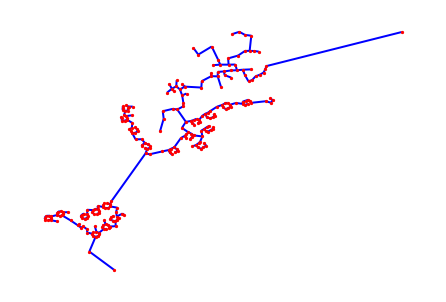

In [58]:
rousys.min_spn_tre()

## Optimising system investments and operation

In [59]:
inosys = pe.inosys('wat_inv', ref_bus = 260)

In [60]:
inosys.solve(solver = 'cbc', onlyopr = False, invest = False)

Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Aug 21 2017 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpol6ahk8z.pyomo.lp -stat=1 -solve -solu /tmp/tmpol6ahk8z.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 8338 (-49633) rows, 11992 (-26257) columns and 34604 (-118905) elements
Statistics for presolved model


Problem has 8338 rows, 11992 columns (5088 with objective) and 34604 elements
There are 2425 singletons with objective 
Column breakdown:
408 of type 0.0->inf, 1104 of type 0.0->up, 120 of type lo->inf, 
6197 of type lo->up, 216 of type free, 0 of type fixed, 
0 of type -inf->0.0, 48 of type -inf->up, 3899 of type 0.0->1.0 
Row breakdown:
2396 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
3985 of type E other, 120 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 997 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 840 of type Range other, 
0 of type Free 
Presol

### Optimisation results

In [61]:
### Total Investment and Operational Costs

In [62]:
inosys.resCost()

,total costs,84137.822
0,total investment costs,66479.536
1,total operation costs,17658.286


### Number and capacity of battery units installed

In [63]:
inosys.resBat()

,Installed Capacity (kW),Bus
Unit,,
1,57.0,260
2,0.0,260
3,0.0,260
4,0.0,260
5,0.0,260


### Number and capacity of solar units installed

In [64]:
inosys.resSolar()

,Installed Capacity (kW),Bus
Unit,,
1,85.0,260
2,100.0,260
3,42.0,260
4,100.0,260
5,100.0,260


### Number and capacity of diesel units installed

In [65]:
inosys.resConv()

,Installed Capacity (kW),Bus
Unit,,
1,18.5,260
2,2.5,260


### Amount of unserved load demand

In [66]:
inosys.resCurt()

,0,1,2,3,4,5,6,7,8,9,...,251,252,253,254,255,256,257,258,259,260
Hour,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
